In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Data preprocessing and visualization
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Regression analysis
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Natural language processing
import string
from nltk.corpus import stopwords 
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Deep learning
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Prepare the dataset

We'll use the Wine Tasting dataset [available on Kaggle](https://www.kaggle.com/mysarahmadbhat/wine-tasting)

In [3]:
# Adjust path
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/wine_prices/winemag-data-130k-v2.csv')

In [4]:
df.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### Preprocess and clean data

#### Replace null strings with 'None'

In [5]:
print(f'The shape is {df.shape}\n')
df.info()

The shape is (129971, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float6

In [6]:
# Drop rows where the country or variety is null
df = df.dropna(subset=['country','variety'])

In [7]:
# Replace null strings with 'None'
replace_nan = ['designation',
               'region_1',
               'region_2',
               'taster_name',
               'taster_twitter_handle']
for col in replace_nan:
    df[col] = df[col].replace(np.nan, 'None')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Replace missing prices with the mean for their country

In [8]:
# Determine the percentage of missing prices
(df['price'].isna().sum() / df['price'].shape[0]) * 100

6.921874879721647

In [9]:
# Calculate the mean price for each country
df_avg = df[['country','price']]
df_avg = df_avg.groupby(by='country').mean()
df_avg.head()

,price
country,
Argentina,24.510117
Armenia,14.500000
Australia,35.437663
Austria,30.762772
Bosnia and Herzegovina,12.500000


In [10]:
# Takes the average price from df_avg and replaces null prices in df
# The .dropna() drops the one null value remaining
df = df.set_index('country').combine_first(df_avg).reset_index().dropna()

In [11]:
df = df.set_index('id')
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
id,,,,,,,,,,,,,
16,Argentina,"Baked plum, molasses, balsamic vinegar and che...",Felix,87,30.0,Other,Cafayate,None,Michael Schachner,@wineschach,Felix Lavaque 2010 Felix Malbec (Cafayate),Malbec,Felix Lavaque
17,Argentina,Raw black-cherry aromas are direct and simple ...,Winemaker Selection,87,13.0,Mendoza Province,Mendoza,None,Michael Schachner,@wineschach,Gaucho Andino 2011 Winemaker Selection Malbec ...,Malbec,Gaucho Andino
183,Argentina,With attractive melon and other tropical aroma...,None,88,12.0,Other,Salta,None,Michael Schachner,@wineschach,Alamos 2007 Torrontés (Salta),Torrontés,Alamos
224,Argentina,Blackberry and road-tar aromas are dark and st...,Lunta,90,22.0,Mendoza Province,Luján de Cuyo,None,Michael Schachner,@wineschach,Mendel 2014 Lunta Malbec (Luján de Cuyo),Malbec,Mendel
231,Argentina,"Meaty and rubbery, but that's young Bonarda. T...",None,85,10.0,Mendoza Province,Mendoza,None,Michael Schachner,@wineschach,Andean Sky 2007 Bonarda (Mendoza),Bonarda,Andean Sky


### Exploratory data analysis

#### Manual one-hot-encoding for new world vs. old world countries

In [12]:
# Apologies for the long, ugly lists!
# New world vs. old world classifications from Wine Folly
new_world_list = [
    'Argentina',
    'Australia',
    'Brazil',
    'Canada',
    'Chile',
    'China',
    'Egypt',
    'India',
    'Mexico',
    'New Zealand',
    'Peru',
    'South Africa',
    'US',
    'Uruguay'
]

In [13]:
# Ancient world wines are grouped in with old world wines
old_world_list = [
    'Armenia',
    'Austria',
    'Bosnia and Herzegovina',
    'Bulgaria',
    'Croatia',
    'Cyprus',
    'Czech Republic',
    'England',
    'France',
    'Georgia',
    'Germany',
    'Greece',
    'Hungary',
    'Israel',
    'Italy',
    'Lebanon',
    'Luxembourg',
    'Macedonia',
    'Moldova',
    'Morocco',
    'Portugal',
    'Romania',
    'Serbia',
    'Slovakia',
    'Slovenia',
    'Spain',
    'Switzerland',
    'Turkey',
    'Ukraine'
]    

In [14]:
# Creates boolean masks for new world and old world countries
df['new_world'] = df['country'].apply(lambda x: x in new_world_list)
df['old_world'] = df['country'].apply(lambda x: x in old_world_list)

#### Creates separate dataframes with and without price outliers

In [45]:
# Remove price outliers
df_no_outliers = df[(np.abs(stats.zscore(df['price'])) < 3)]

In [46]:
# Original dataframe
df.describe()

,points,price
count,129906.000000,129906.000000
mean,88.447085,35.547989
std,3.040064,39.616034
min,80.000000,4.000000
25%,86.000000,18.000000
50%,88.000000,27.000000
75%,91.000000,41.139120
max,100.000000,3300.000000


In [47]:
# Dataframe without outliers
df_no_outliers.describe()

,points,price
count,128689.000000,128689.000000
mean,88.396926,33.141217
std,2.998895,22.125015
min,80.000000,4.000000
25%,86.000000,18.000000
50%,88.000000,27.000000
75%,91.000000,41.139120
max,100.000000,154.000000


Price distribution excluding outliers


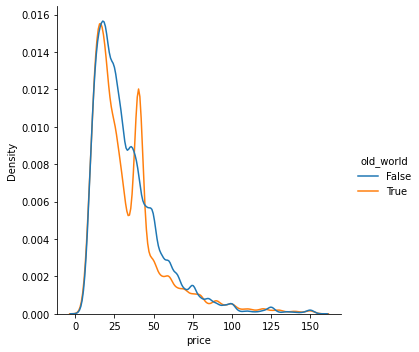

In [48]:
print('Price distribution excluding outliers')
sns.displot(data=df_no_outliers, 
            x='price', 
            hue='old_world',
            kind='kde');

In [49]:
# Let's take a closer look at the outliers
df_outliers = df[(np.abs(stats.zscore(df['price'])) >= 3)]

In [50]:
df_outliers.describe()

,points,price
count,1217.000000,1217.000000
mean,93.751027,290.046836
std,2.671973,224.546019
min,83.000000,155.000000
25%,93.000000,179.000000
50%,94.000000,225.000000
75%,95.000000,310.000000
max,100.000000,3300.000000


Price distribution of outliers


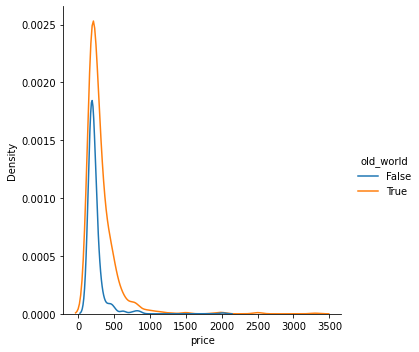

In [53]:
print('Price distribution of outliers')
sns.displot(data=df_outliers, 
            x='price', 
            hue='old_world',
            kind='kde');

#### Correlation heatmapping

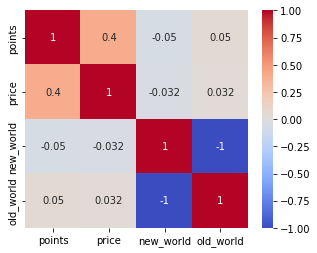

In [15]:
plt.figure(figsize = (5,4))
sns.heatmap(df.corr(), 
            cmap='coolwarm', 
            annot = True, 
            annot_kws={"size": 10});

Initial takeaways from all data:
* Points is moderately correlated (0.4) with price
* New_world has a very small negative correlation (-0.032) with price
* Conversely, old_world has a very small positive correlation (0.032) with price

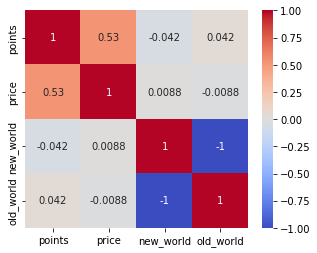

In [54]:
plt.figure(figsize = (5,4))
sns.heatmap(df_no_outliers.corr(), 
            cmap='coolwarm', 
            annot = True, 
            annot_kws={"size": 10});

When outliers are excluded:
* Points is more closely correlated (0.53) with price
* The correlation between old_world and new_world is less pronounced

#### Interactive plot comparing mean price and points by country

In [16]:
# Creates a smaller dataframe that groups by country
country_avg = df[['points','price','country','variety', 'new_world', 'old_world']]
country_avg = df.groupby('country').mean()
country_avg['count'] = df.groupby('country')['country'].count()
# Converts new_world and old_world to boolean for the sake of plotting
country_avg['new_world'] = country_avg['new_world'].astype('boolean')
country_avg['old_world'] = country_avg['old_world'].astype('boolean')
country_avg = country_avg.reset_index()
country_avg.head()

,country,points,price,new_world,old_world,count
0,Argentina,86.710263,24.510117,True,False,3800
1,Armenia,87.500000,14.500000,False,True,2
2,Australia,88.580507,35.437663,True,False,2329
3,Austria,90.101345,30.762772,False,True,3345
4,Bosnia and Herzegovina,86.500000,12.500000,False,True,2


In [17]:
# Creates an interactive Plotly Express plot
fig = px.scatter(country_avg, 
                 x='price', 
                 y='points',
                 size='count', 
                 hover_name='country',
                 color='new_world',
                 size_max=100)
fig.update_xaxes(range=[0, 60])
fig.update_yaxes(range=[84, 92])
fig.show()

## Initial linear regression

In [18]:
df_reg = df[['points','price','new_world', 'old_world']]

In [19]:
# Define X and y
X = df_reg[['points', 'new_world', 'old_world']]
y = df_reg['price']

In [20]:
# We'll use a 70/30 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
# We'll use the RobustScaler because it is less sensitive to outliers
scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))

In [22]:
# Fit the model on scaled training data
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [23]:
train_score = model.score(X_train, y_train)
print('The training score is {:.2f}'.format(train_score))

The training score is 0.16


In [24]:
# Transform X_test after the train-test split to avoid data leakage
X_test = scaler.transform(X_test)

In [25]:
test_score = model.score(X_test, y_test)
print('The test score is {:.2f}'.format(test_score))

The test score is 0.18


We're able to predict about 18% of the variance in price by using only points and its new world/old world classification!

## Preprocessing reviews for NLP

In [18]:
# Let's print a few example reviews to better understand the text data
rand_five = np.random.randint(low=0, high=len(df['description']), size=5)
for i in range(len(rand_five)):
    print(f"{df['description'][rand_five[i]]}\n")

It's rare to see a varietal bottle of Petit Verdot come out of this appellation, let alone a single vineyard offering but this one clearly deserves it. The aromas of flowers, soil, green herbs and purple fruit are light and brooding and lead to full but in balance black-fruit flavors. A lengthy finish caps it off.

The nose of this wine recalls chilled fruit salad, with aromas of melon, pineapple and Delicious apple. Engaging flavors of pineapple, passion fruit, vanilla and clove fill the softly textured mouth and persist into the cooling finish.

This is a tip-top appellation blend from a winery based in the Lompoc Wine Ghetto, showing fresh-pressed raspberries, fennel pollen, dried rose petals and hibiscus on the nose. It's tightly wound on the spicy palate, with light cranberry, thyme, marjoram and Earl Grey tea flavors.

Cab Franc from Southern Oregon may not be on your radar, but this bottle suggests it should be. Violets and leather perfume the nose, introducing soft, round purpl

In [19]:
# Make reviews lowercase
df['clean'] = df['description'].str.lower()

In [20]:
# Remove punctuation
# Adds em-dash (long hyphen) to default punctuation list
punc = string.punctuation
punc += '—'
def remove_punctuation(text):
    for p in punc:
        text = text.replace(p, ' ')
    return text

df['clean'] = df['clean'].apply(remove_punctuation)

In [21]:
df['clean'][0]

'aromas include tropical fruit  broom  brimstone and dried herb  the palate isn t overly expressive  offering unripened apple  citrus and dried sage alongside brisk acidity '

In [22]:
# Installs essential NLTK libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
# Tokenize reviews and remove stopwords
# Stopwords are words that are so common that they are meaningless in topic analysis
stop_words = set(stopwords.words('english')) 

def remove_stopwords (text):
    tokenized = word_tokenize(text)
    without_stopwords = [word for word in tokenized if not word in stop_words]
    return without_stopwords

## Topic analysis with Latent Dirichlet Allocation (LDA)

In [35]:
# Overwrites X and y from the linear regression
# For now, our only feature is the description
X = df['clean']
y = df['points']

In [36]:
# Vectorizer uses the custom remove_stopwords function from earlier
vectorizer = CountVectorizer(tokenizer=remove_stopwords)
X = vectorizer.fit_transform(X)

In [37]:
# Instantiates and fits an LDA model with 20 components
lda_model = LatentDirichletAllocation(n_components=20).fit(X)

In [38]:
# Plotting function adapted from the LDA example provided by Sci-kit Learn
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(5, 4, figsize=(45, 20), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

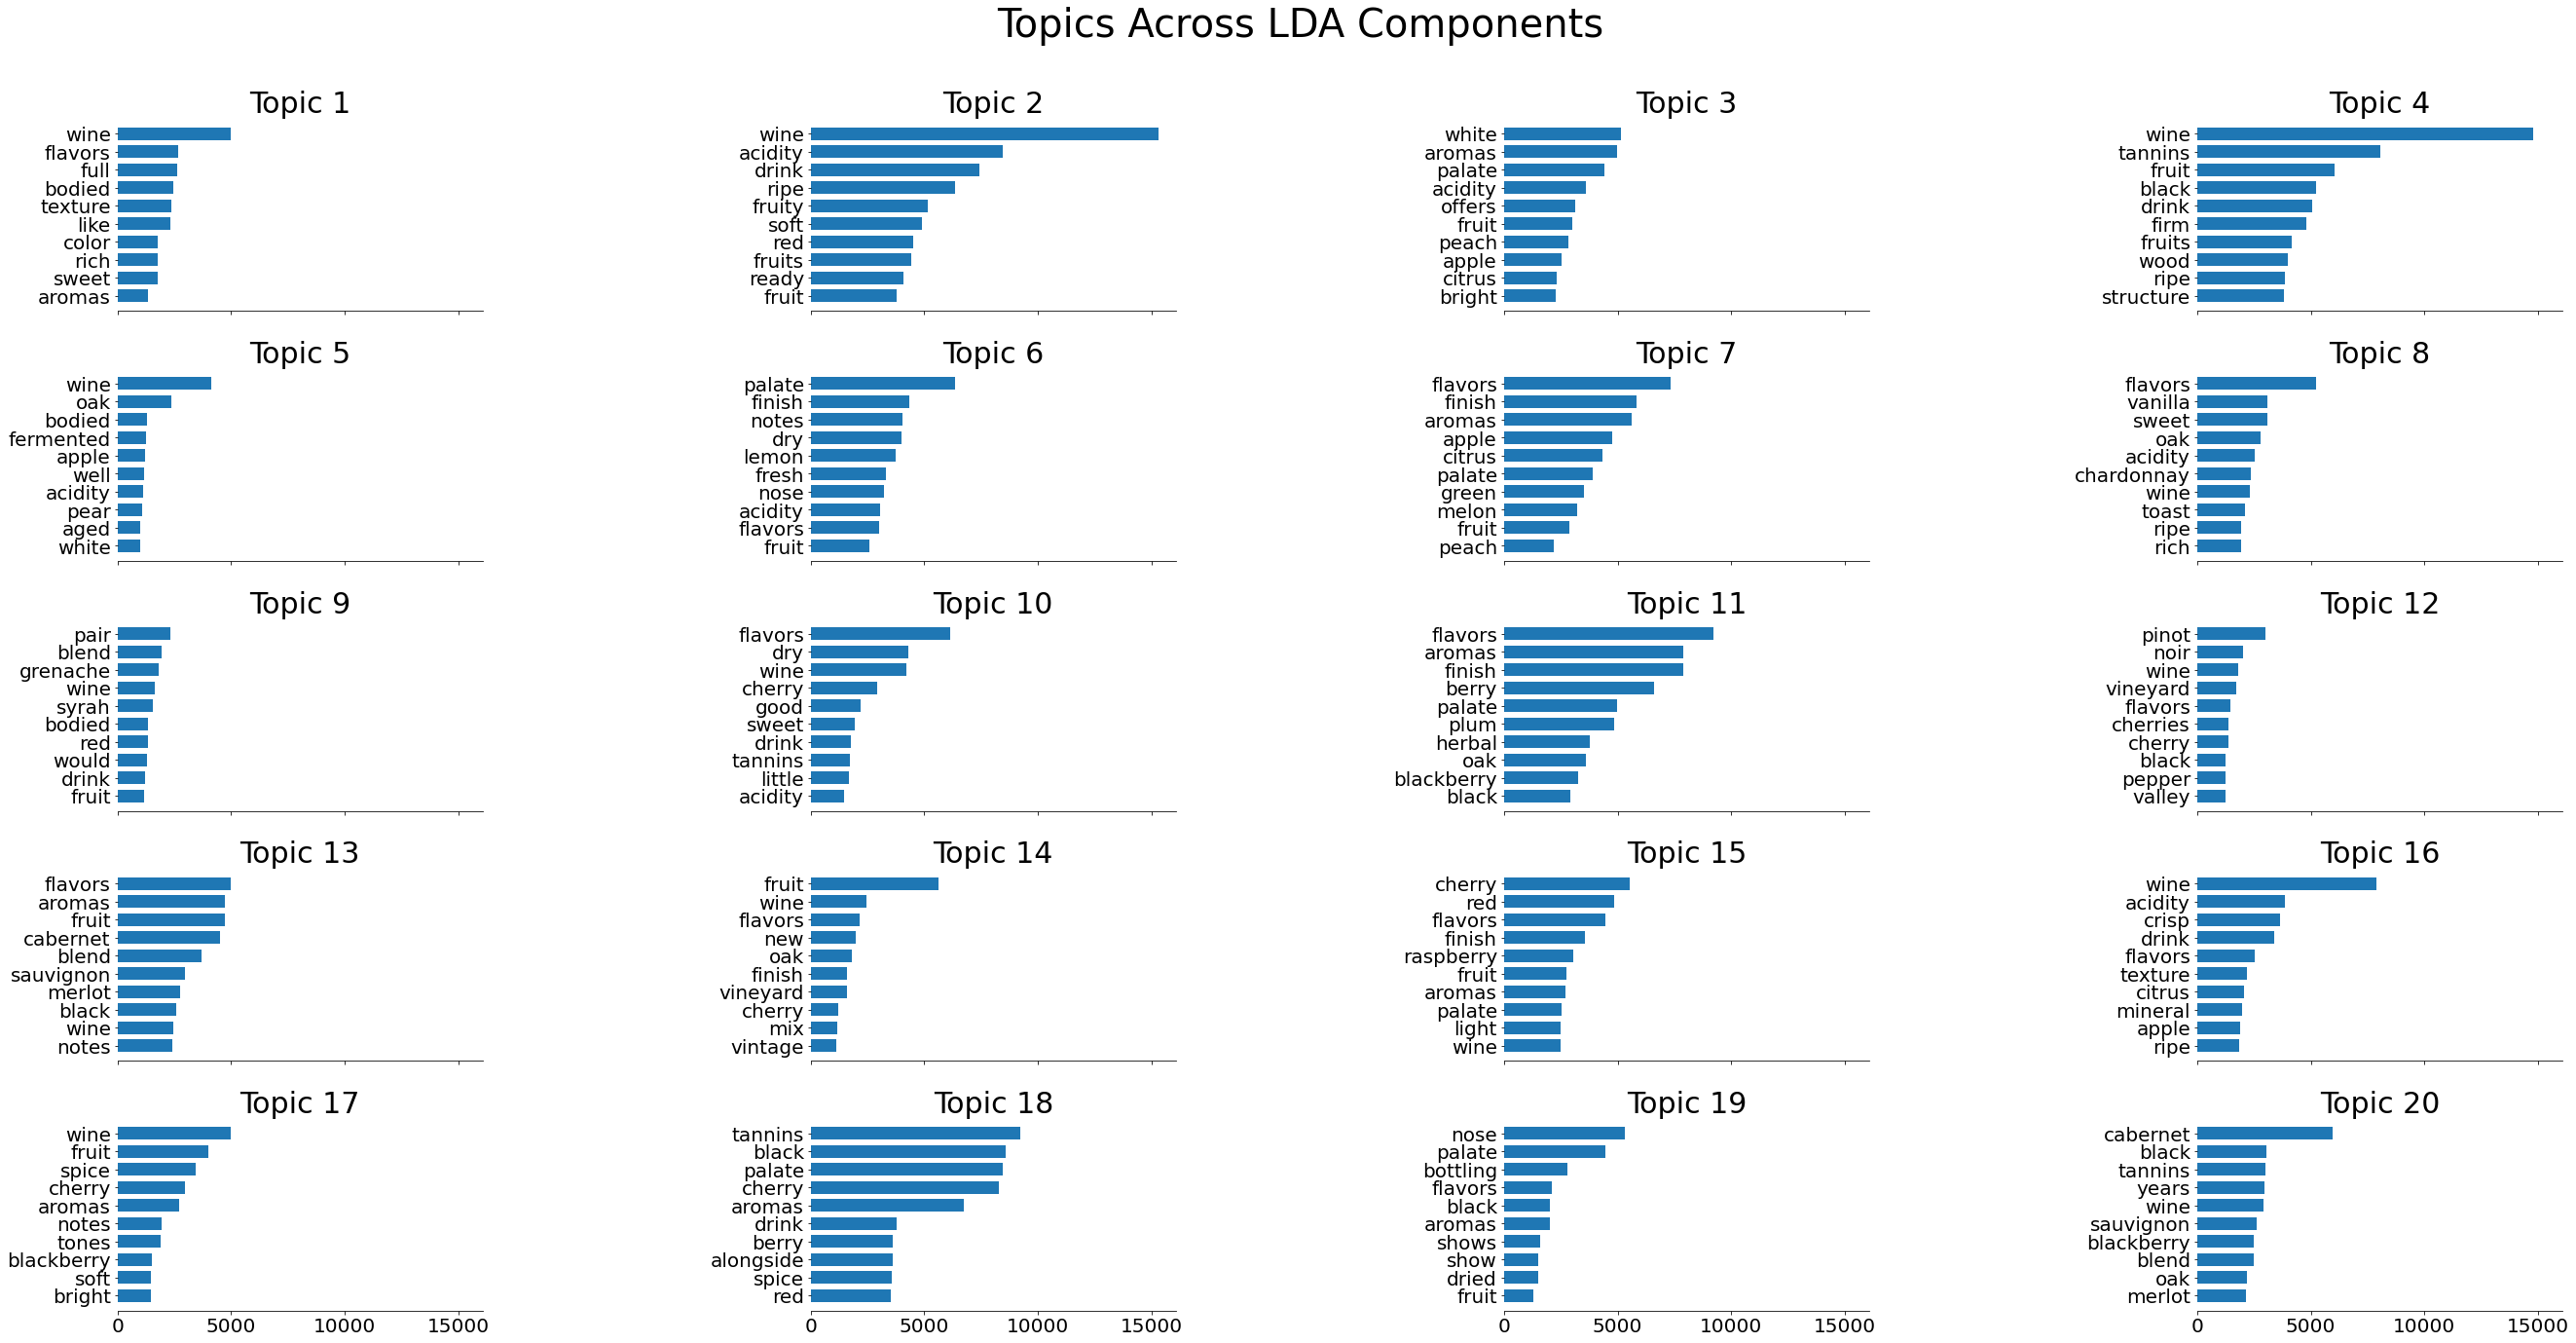

In [39]:
n_components = 20
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda_model, feature_names, n_top_words, "Topics Across LDA Components")

Based on the initial LDA, there are several words that are too frequent to be useful, such as:

* wine
* flavors
* aromas
* notes
* palate


In [40]:
# Refresh X and y
X = df['clean']
y = df['points']

In [24]:
# Append our stopwords list with wine-specific stopwords
wine_stopwords = stopwords.words('english')
custom_words = ['wine','flavors','aromas','notes','palate']
wine_stopwords.extend(custom_words)

def remove_wine_stopwords (text):
    tokenized = word_tokenize(text)
    without_stopwords = [word for word in tokenized if not word in wine_stopwords]
    return without_stopwords

In [42]:
# Create a new CountVectorizer instance that uses the updated stopwords list
updated_vectorizer = CountVectorizer(tokenizer=remove_wine_stopwords)
X = updated_vectorizer.fit_transform(X)

In [43]:
# Instantiates and fits a new LDA model with 20 components
lda_model_updated = LatentDirichletAllocation(n_components=20).fit(X)

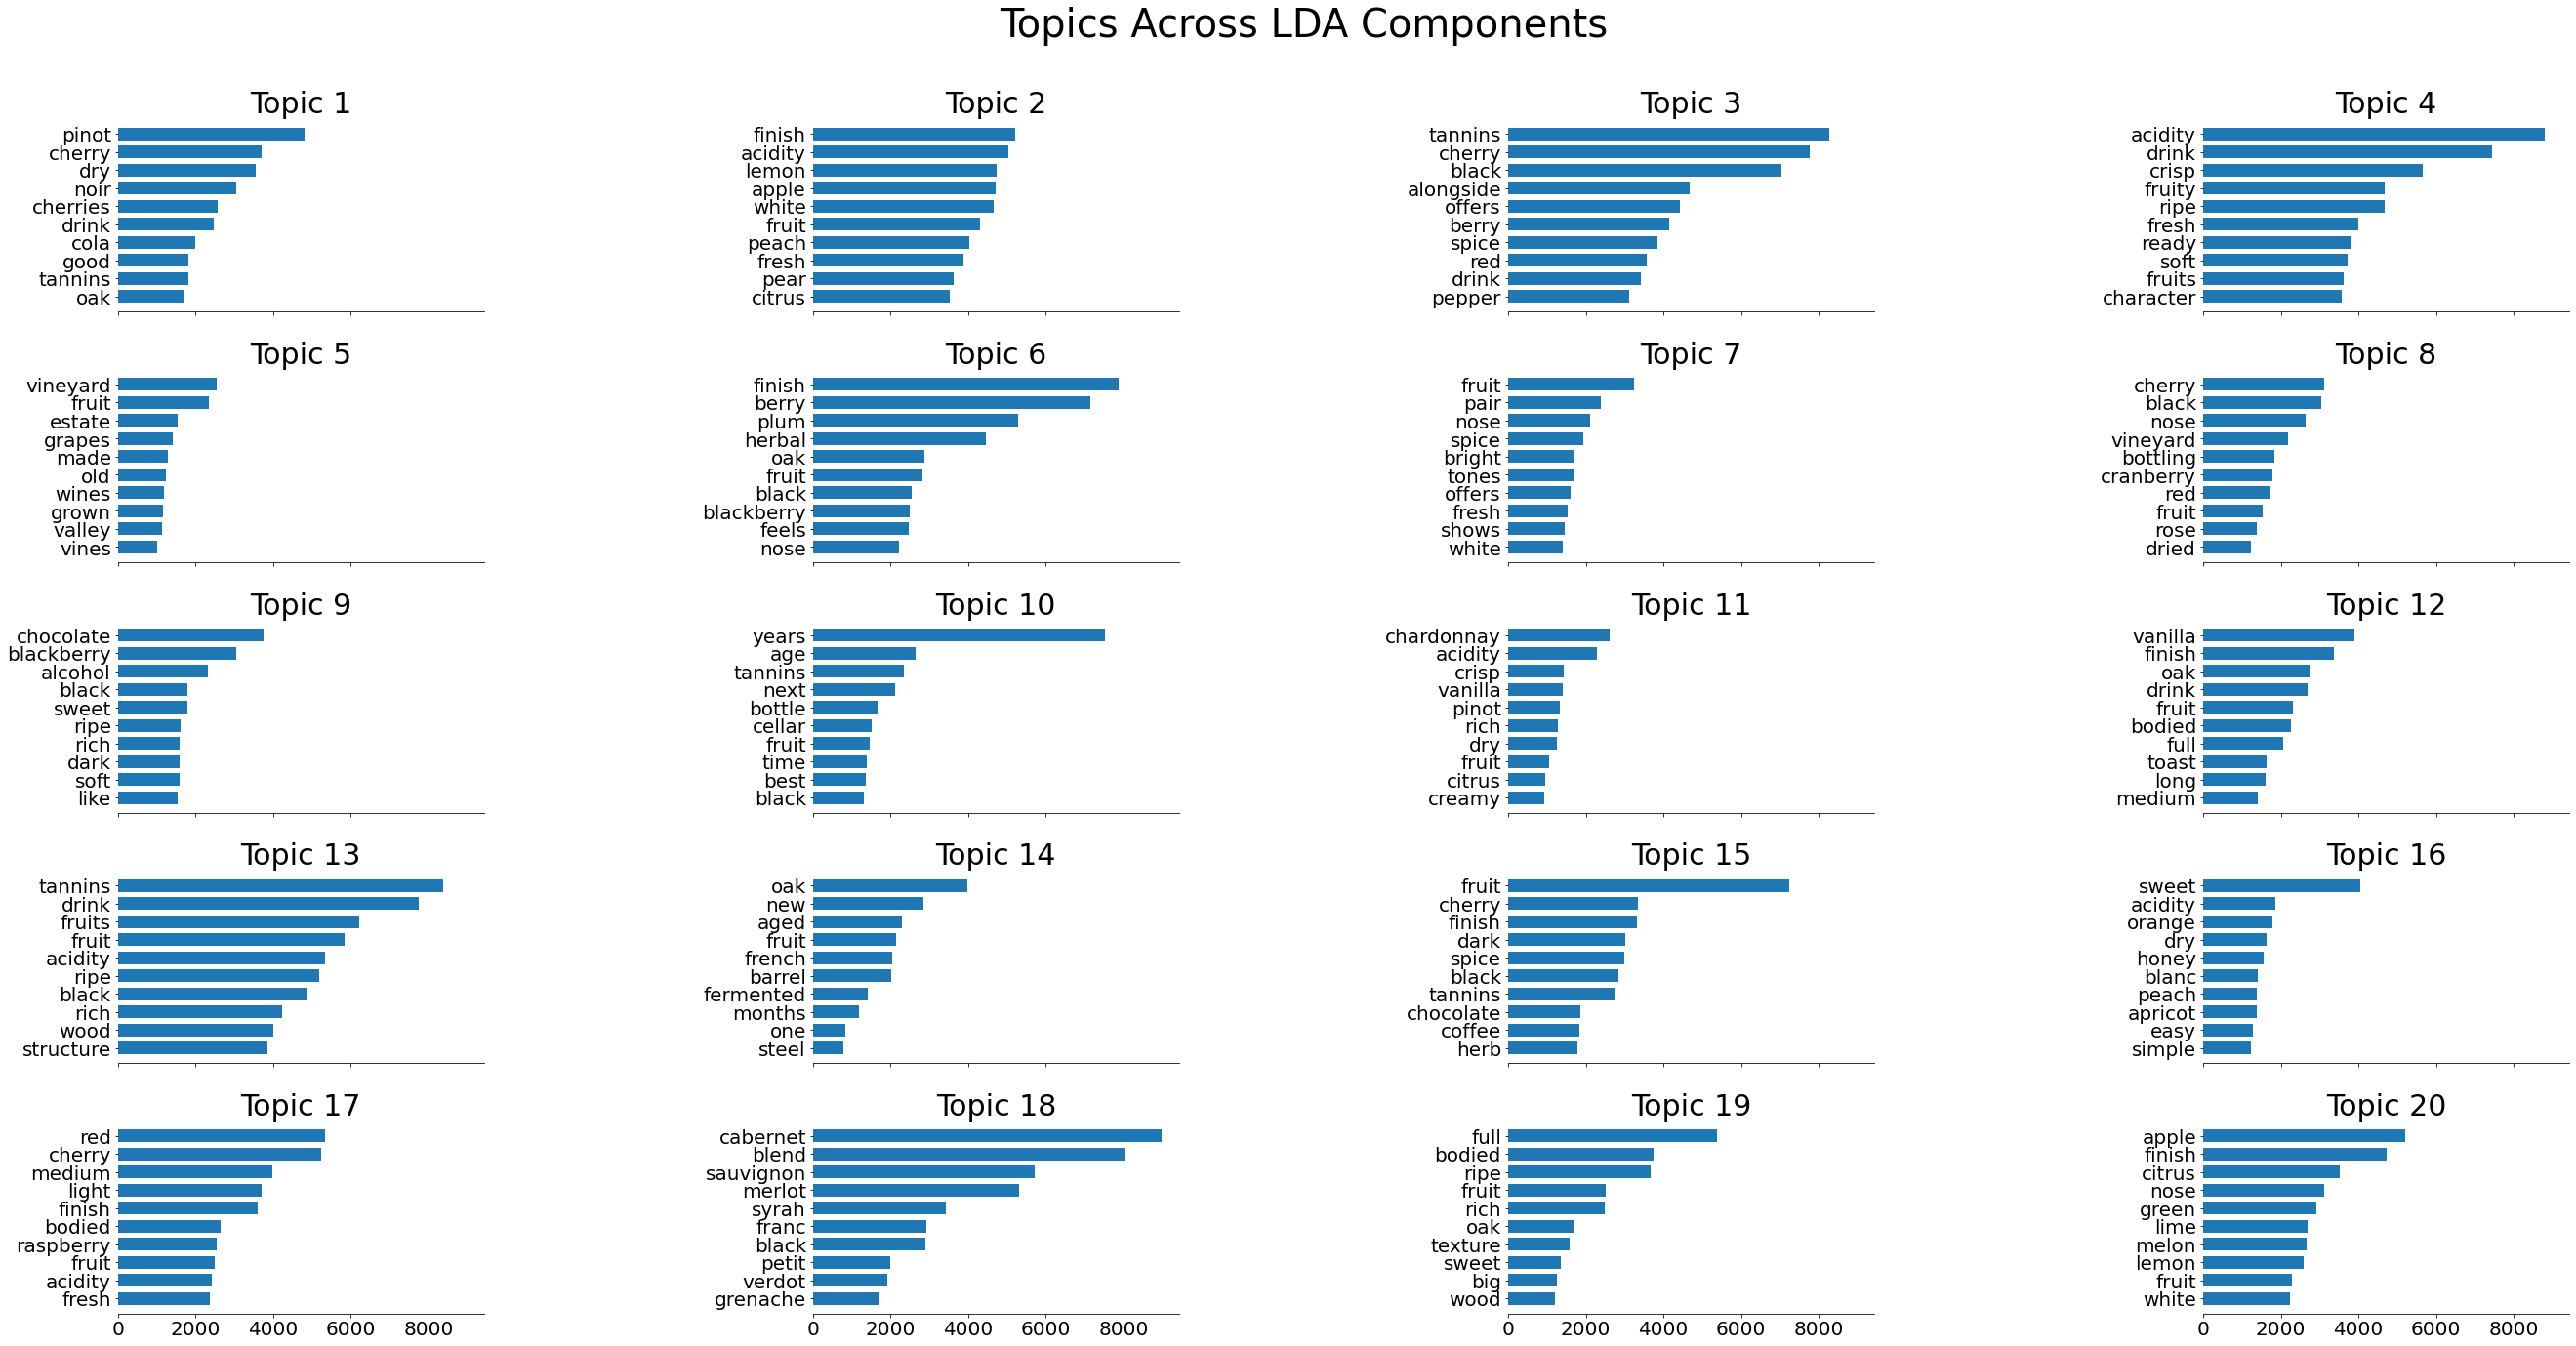

In [44]:
n_components = 20
n_top_words = 10
feature_names = updated_vectorizer.get_feature_names_out()
plot_top_words(lda_model_updated, feature_names, n_top_words, "Topics Across LDA Components")

## Word2Vec modeling

In [45]:
# !pip install Word2Vec

In [32]:
# Reset X and y
X = df['clean']
y = df['points']

In [33]:
# We'll use a 70/30 train/test split again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [34]:
X_train[0]

'aromas include tropical fruit  broom  brimstone and dried herb  the palate isn t overly expressive  offering unripened apple  citrus and dried sage alongside brisk acidity '

In [35]:
# Tokenize and remove stopwords
X_train = X_train.apply(remove_wine_stopwords)
X_test = X_test.apply(remove_wine_stopwords)

In [36]:
X_train[0]

['include',
 'tropical',
 'fruit',
 'broom',
 'brimstone',
 'dried',
 'herb',
 'overly',
 'expressive',
 'offering',
 'unripened',
 'apple',
 'citrus',
 'dried',
 'sage',
 'alongside',
 'brisk',
 'acidity']

In [37]:
# Instantiate Word2Vec model
wv_model = Word2Vec(sentences=X_train, size=50, window=5, min_count=3)

In [38]:
# Check that the model makes sense by testing a few features
wv_model.wv.doesnt_match(['strawberry', 'cherry', 'berry', 'smoke'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



'smoke'

In [53]:
# Determines the words that are most similar to 'young'
wv_model.wv.most_similar('young')

[('youthful', 0.7681035399436951),
 ('primary', 0.6007099747657776),
 ('developing', 0.5936776399612427),
 ('although', 0.5751158595085144),
 ('needs', 0.5728118419647217),
 ('integrating', 0.5476011037826538),
 ('need', 0.5301868915557861),
 ('ready', 0.5192292928695679),
 ('room', 0.4993801414966583),
 ('packed', 0.49455931782722473)]

In [54]:
wv_model.wv.most_similar('thin')

[('watery', 0.8553096055984497),
 ('dilute', 0.8026225566864014),
 ('prickly', 0.7217463850975037),
 ('harsh', 0.7199683785438538),
 ('simple', 0.7140972018241882),
 ('pleasant', 0.6933644413948059),
 ('generic', 0.6919246315956116),
 ('lean', 0.689965009689331),
 ('confected', 0.6864743232727051),
 ('sour', 0.6832061409950256)]

In [55]:
# Arithmetic with word vectors
# In simple terms, it finds words that are similar to 'herbaceous' but not 'earthy'
# It finds vinho verde, a traditionally herbaceous but not earthy wine!
v_herbaceous = wv_model.wv['herbaceous']
v_earthy = wv_model.wv['earthy']
v_result = v_herbaceous - v_earthy
wv_model.wv.similar_by_vector(v_result)

[('arinto', 0.6471152305603027),
 ('blancs', 0.6233798861503601),
 ('vaz', 0.6212128400802612),
 ('verde', 0.6142553091049194),
 ('pires', 0.6113166809082031),
 ('fernão', 0.6086826920509338),
 ('alvarinho', 0.6052533388137817),
 ('vinho', 0.5736961960792542),
 ('champagne', 0.5730040073394775),
 ('crispest', 0.5608458518981934)]

In [70]:
wv_model.save('/content/drive/MyDrive/Colab Notebooks/wine_prices/wv_model.model')

In [39]:
# Function to convert a sentence into a matrix
def embed_sentence(wv_model, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in wv_model.wv:
            embedded_sentence.append(wv_model.wv[word])
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)  
    return embed

In [57]:
# Embed sentences
X_train_embed = embedding(wv_model, X_train)
X_test_embed = embedding(wv_model, X_test)

In [58]:
# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post')
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post')

## Long Short-Term Memory (LSTM) model to predict points based on reviews

The goal of this LSTM model is to predict the points a wine would be rated (e.g. 92 out of 100) based on its review.

In [59]:
# Initializes an LSTM model
def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(loss='mse',
                  optimizer='rmsprop',
                  metrics=['mse'])
    return model

In [60]:
model = init_model()

In [61]:
# Trains the model
es = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train_pad, y_train, 
          batch_size=32,
          epochs=100,
          validation_split=0.3,
          callbacks=es
         )

Epoch 1/100
1990/1990 [==============================] - 51s 17ms/step - loss: 964.7054 - mse: 964.7054 - val_loss: 4.1349 - val_mse: 4.1349
Epoch 2/100
1990/1990 [==============================] - 22s 11ms/step - loss: 3.8968 - mse: 3.8968 - val_loss: 4.3738 - val_mse: 4.3738
Epoch 3/100
1990/1990 [==============================] - 23s 11ms/step - loss: 3.5596 - mse: 3.5596 - val_loss: 4.0301 - val_mse: 4.0301
Epoch 4/100
1990/1990 [==============================] - 22s 11ms/step - loss: 3.4198 - mse: 3.4198 - val_loss: 3.5292 - val_mse: 3.5292
Epoch 5/100
1990/1990 [==============================] - 23s 12ms/step - loss: 3.3337 - mse: 3.3337 - val_loss: 3.3519 - val_mse: 3.3519
Epoch 6/100
1990/1990 [==============================] - 24s 12ms/step - loss: 3.2834 - mse: 3.2834 - val_loss: 3.4837 - val_mse: 3.4837
Epoch 7/100
1990/1990 [==============================] - 22s 11ms/step - loss: 3.2452 - mse: 3.2452 - val_loss: 3.7628 - val_mse: 3.7628
Epoch 8/100
1990/1990 [==============

In [66]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 50)          0         
                                                                 
 lstm (LSTM)                 (None, 20)                5680      
                                                                 
 dense (Dense)               (None, 15)                315       
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 6,011
Trainable params: 6,011
Non-trainable params: 0
_________________________________________________________________


In [63]:
# Saves model
model.save('/content/drive/MyDrive/Colab Notebooks/wine_prices/model1.h5')

In [64]:
train_score = model.evaluate(X_train_pad, y_train)
print('The training score is {:.2f}'.format(train_score[0]))

2842/2842 [==============================] - 13s 5ms/step - loss: 2.9661 - mse: 2.9661
The training score is 2.97


In [65]:
test_score = model.evaluate(X_test_pad, y_test)
print('The test score is {:.2f}'.format(test_score[0]))

1218/1218 [==============================] - 11s 7ms/step - loss: 3.0486 - mse: 3.0486
The test score is 3.05


## LSTM for price prediction based on reviews

In [46]:
# Reset X and y and use df_no_outliers
X = df_no_outliers['clean']
y = df_no_outliers['price']

In [47]:
# We'll use a 70/30 train/test split again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [48]:
# Tokenize and remove stopwords
X_train = X_train.apply(remove_wine_stopwords)
X_test = X_test.apply(remove_wine_stopwords)

In [49]:
# Embed sentences
X_train_embed = embedding(wv_model, X_train)
X_test_embed = embedding(wv_model, X_test)

In [50]:
# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post')
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post')

In [51]:
# Initializes an LSTM model for price prediction
optimizer = Adam(learning_rate=0.0005)
def init_price_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(32, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse'])
    return model

In [52]:
price_model = init_price_model()

In [53]:
filepath = '/content/drive/MyDrive/Colab Notebooks/wine_prices/model.{epoch:02d}-{val_loss:.2f}.h5'

# Trains the model
es = [EarlyStopping(patience=5, restore_best_weights=True),
      ModelCheckpoint(filepath=filepath, save_best_only=True)]

price_model.fit(X_train_pad, y_train, 
          batch_size=32,
          epochs=100,
          validation_split=0.3,
          callbacks=es
         )

Epoch 1/100
1947/1947 [==============================] - 431s 220ms/step - loss: 502.5479 - mse: 502.5479 - val_loss: 304.0623 - val_mse: 304.0623
Epoch 2/100
1947/1947 [==============================] - 438s 225ms/step - loss: 313.3172 - mse: 313.3172 - val_loss: 269.4745 - val_mse: 269.4745
Epoch 3/100
1947/1947 [==============================] - 428s 220ms/step - loss: 289.2317 - mse: 289.2317 - val_loss: 256.8922 - val_mse: 256.8922
Epoch 4/100
1947/1947 [==============================] - 435s 223ms/step - loss: 276.3782 - mse: 276.3782 - val_loss: 251.7168 - val_mse: 251.7168
Epoch 5/100
1947/1947 [==============================] - 433s 223ms/step - loss: 269.3625 - mse: 269.3625 - val_loss: 247.0752 - val_mse: 247.0752
Epoch 6/100
1947/1947 [==============================] - 424s 218ms/step - loss: 262.7778 - mse: 262.7778 - val_loss: 244.5578 - val_mse: 244.5578
Epoch 7/100
1947/1947 [==============================] - 424s 218ms/step - loss: 258.5233 - mse: 258.5233 - val_loss: 